## Imports

In [2]:
import os
import sys

In [3]:
os.getcwd()
os.chdir('../')
os.chdir('code')

In [6]:
os.getcwd()

'/Users/AriaW/Desktop/159/project-beta/project-beta-1/code'

In [7]:
from utils import vmt_utils
from utils import regression
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 
import copy
import time
import nibabel as nib
import cPickle

In [8]:
%matplotlib inline

In [9]:
reload(regression)

<module 'utils.regression' from 'utils/regression.pyc'>

## Get masked data

In [10]:
# data = np.load('../data/masked_data_50k.npy')

In [11]:
data = np.load('../data/filtered_data.npy')

In [12]:
data.shape

(55468, 3543)

In [13]:
data_normalized = stats.zscore(data,axis=1,ddof=1)

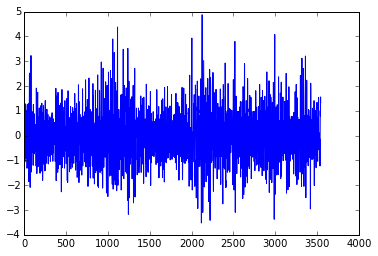

In [64]:
plt.plot(data_normalized[16188,:])
plt.savefig('../figure/normailzed_data.jpg')

In [14]:
vvar = np.var(data,axis=1)

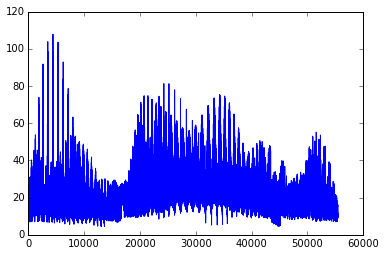

In [11]:
plt.plot(vvar)
plt.savefig('../figure/data_variance_normalization.jpg')

## Get feature space

In [15]:
# Get stimulus feature spaces
stim_fs_fpath = '../description_pp/design_matrix_1.npy'
stim_fs_file = np.load(stim_fs_fpath)
stim_fs_file = stim_fs_file[:3543,:]

In [16]:
stim_fs_file.shape

(3543, 1155)

## Separate Trainig and testing data

In [28]:
e, v = 500, 143

In [29]:
stim_fs_est = stim_fs_file[:e,:]
stim_fs_val = stim_fs_file[:v,:]

In [30]:
print('Estimation feature space shape: %s'%repr(stim_fs_est.shape))
print('Validation feature space shape: %s'%repr(stim_fs_val.shape))

Estimation feature space shape: (500, 1155)
Validation feature space shape: (143, 1155)


In [31]:
data_est = data_normalized[...,:e]
data_val = data_normalized[...,:v]

In [32]:
data_est_masked = data_est.T
data_val_masked = data_val.T
# Show size of masked data
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

Size of masked estimation data is (500, 55468)
Size of masked validation data is (143, 55468)


## Set up feature space matrix to do regression

In [33]:
# Create lagged stimulus matrix
efs = vmt_utils.add_lags(stim_fs_est,[2,3,4])
vfs = vmt_utils.add_lags(stim_fs_val,[2,3,4])
print efs.shape
# Add column of ones
efs = vmt_utils.add_constant(efs,is_first=True)
vfs = vmt_utils.add_constant(vfs,is_first=True)
print efs.shape

(500, 3465)
(500, 3466)


# Subset data and stimuli

In [34]:
ts = 3000 #training subset
es = 543 #estimation subset

In [35]:
efs = efs[:ts,:]
vfs = vfs[:es,:]
print efs.shape
print vfs.shape

(500, 3466)
(143, 3466)


In [36]:
data_est_masked = data_est_masked[:ts,:]
data_val_masked = data_val_masked[:es,:]
print data_est_masked.shape
print data_val_masked.shape

(500, 55468)
(143, 55468)


## Run regression

In [37]:
reload(vmt_utils)

<module 'utils.vmt_utils' from 'utils/vmt_utils.pyc'>

In [38]:
alpha = np.logspace(0,6,10)
alpha

array([  1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02,   4.64158883e+02,   2.15443469e+03,
         1.00000000e+04,   4.64158883e+04,   2.15443469e+05,
         1.00000000e+06])

In [39]:
# Run regression 
n_splits = 10 # number of subdivisions of validation data for cross validation of ridge parameter (alpha)
n_resamps = 10 # number of times to compute regression & prediction within training data (can be <= n_splits) #default10
chunk_sz = 10000 # number of voxels to fit at once. Memory-saving.
pthr = 0.005 # Ridge parameter is chosen based on how many voxels are predicted above a correlation threshold 
             # for each alpha value (technically it's slightly more complicated than that, see the code). 
             # This p value sets that correlation threshold.
t0 = time.time()

out = regression.ridge_cv(efs,data_est_masked,val_fs=vfs,val_data=data_val_masked,alphas=alpha,n_resamps=n_resamps,
                              n_splits=n_splits,chunk_sz=chunk_sz,pthr=pthr,is_verbose=True)

t1 = time.time()
print("Elapsed time is: %d min, %d sec"%((t1-t0)/60,(t1-t0)%60))

Running split 1/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 2/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 3/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 4/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 5/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 6/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chu

## Make sure estimation procedure chose a reasonable $\alpha$ value
There should be a somewhat obvious maximum in the curve plotted below

In [40]:
# # Plot number of voxels with significant prediction accuracy within the 
# # estimation data for each alpha value
# na = len(out['n_sig_vox_byalpha'])
# plt.plot(range(na),out['n_sig_vox_byalpha'],'ko-',lw=2)
# # plt.xticks(range(na),vmt.regression.DEFAULT_ALPHAS,rotation=45)
# plt.xticks(range(na),alpha,rotation=45)
# plt.xlabel('Regularization parameter')
# _ = plt.ylabel('Number of voxels\naccurately predicted')

## Display prediction accuracy results on the cortical surface

In [41]:
out['cc'].shape

(55468,)

In [42]:
cc = out['cc']
weights = out['weights']

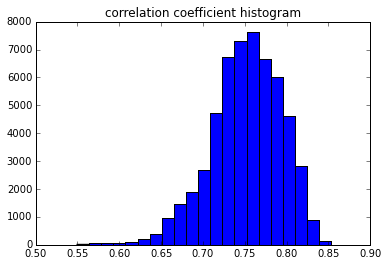

In [43]:
plt.hist(np.nan_to_num(cc),21)
plt.title('correlation coefficient histogram')
plt.savefig('../figure/correlation_coefficient_histogram.jpg')

In [44]:
out['weights'].shape

(3466, 55468)

In [45]:
voxel_idx = np.argsort(cc)[::-1][:100]
voxel_idx

array([ 9571,   398,   109,   401, 10256, 10262, 22041, 21298, 22016,
       22841, 22840, 23714, 22813,   400, 20612, 10951, 22042, 22043,
       12332,   111,  9568,  9569, 10257,   108, 10265, 10945, 22843,
       22787, 13550, 22868,   110, 10270,   399, 22017,  9570,  9576,
       24617,   403,  9577, 10263, 13554, 23716, 20611, 12954, 12333,
       21273, 10264,  9563, 22815, 12327,   402,   112, 23659, 19985,
       10251, 23689, 53073, 53072, 23688, 52204, 23661, 23715,   117,
       22816, 12959, 11650, 23717,   404, 24586, 54353, 10259, 20027,
        8859, 51489,   125, 23687, 52220,  8866,  9567, 22067, 12323,
       13548, 10946, 22867, 22068, 13536,   833, 23474, 10260, 12328,
       10958,   839, 20588, 14063, 11654,  8850, 10954, 22018, 10261, 11655])

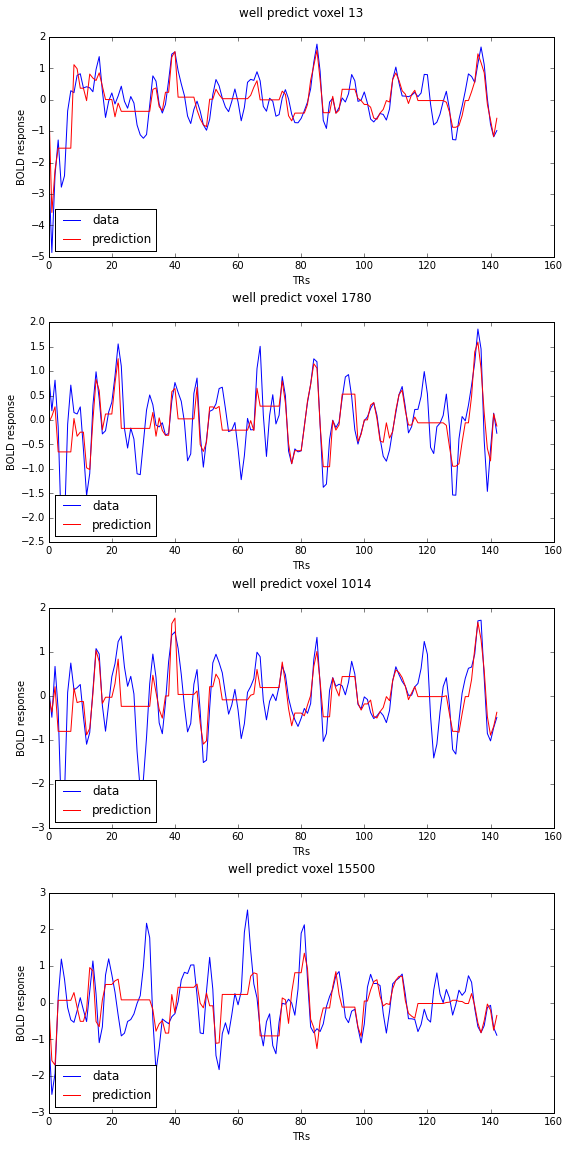

In [50]:
idxx = [13,1780,1014,15500] # hand picked voxels
plt.figure(4,figsize=(8,16))
for n in range(4):
    i = idxx[n]
    pred_activity = vfs.dot(weights[:,i])
    plt.subplot(4,n//4+1,n%4+1)
    l1, = plt.plot(data_val_masked[:400,i],'b')
    l2, = plt.plot(pred_activity[:400,],'r')
    plt.ylabel('BOLD response')
    plt.xlabel('TRs')
    plt.title('well predict voxel %d\n'%i)
    plt.legend([l1, l2], ['data','prediction'],loc=3)
    
plt.tight_layout()
plt.savefig('../ridge_prediciton_resutls.jpg')


In [76]:
sum(cc>0.7)

46746